In [75]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import tqdm as tqdm

##### 파일 다운받고, 파일 경로 안에 저장한 두 파일의 경로 입력!

In [76]:
train_path = '/Users/gyuhuikwon/Desktop/fashion-mnist_train.csv'
test_path = '/Users/gyuhuikwon/Desktop/fashion-mnist_test.csv'

In [77]:
#데이터셋 불러오기
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    X_train = train_data.iloc[:, 1:].values.astype('float32') / 255.0
    y_train = train_data.iloc[:, 0].values.astype('int')
    X_test = test_data.iloc[:, 1:].values.astype('float32') / 255.0
    y_test = test_data.iloc[:, 0].values.astype('int')
    return X_train, y_train, X_test, y_test
 
# 원 핫 인코더
def one_hot_encoder(num_labels, y):
    y_one_hot = np.eye(num_labels)[y]
    return y_one_hot

X_train, Y_train, X_test, Y_test = load_data(train_path, test_path)
y_train_one_hot, y_test_one_hot = one_hot_encoder(10, Y_train), one_hot_encoder(10, Y_test)

#print(len(X_train), len(X_test))
#print(X_train.shape)
#print(y_train_one_hot[0])
#print(Y_train[0])

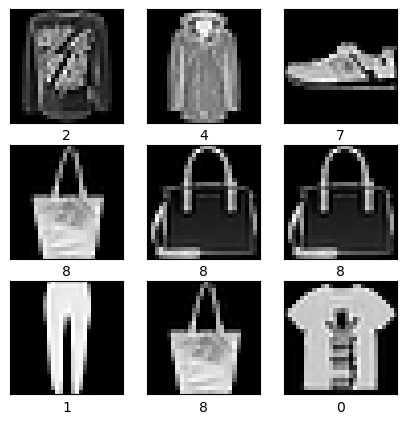

In [78]:
#데이터셋 확인하기
plt.figure(figsize=(5,5))
sample_size = 9
random_idx = np.random.randint(50, size=sample_size)
for i, idx in enumerate(random_idx):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train.reshape(-1,28,28)[idx], cmap='gray')
    plt.xlabel(Y_train[idx])
plt.show()
    

In [79]:
##Initialization
# number of nodes in each layer
input_layer = 784 #28*28
hidden1 = 32
hidden2 = 64
hidden3 = 32
output_layer = 10
np.random.seed(42)

W1 = np.random.randn(input_layer, hidden1)/np.sqrt(input_layer) #(784,32)
W2 = np.random.randn(hidden1, hidden2)/np.sqrt(hidden1) #(32,64)
W3=np.random.randn(hidden2, hidden3)/np.sqrt(hidden2) #(64,32)
W4=np.random.randn(hidden3, output_layer)/np.sqrt(hidden3) #(32,10)

B1=np.zeros((1, hidden1))
B2=np.zeros((1, hidden2))
B3=np.zeros((1, hidden3))
B4=np.zeros((1, output_layer))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    y = np.exp(x) / np.sum(np.exp(x))
    return y

#X_train, Y_train, X_test, Y_test = load_data(train_path, test_path)
#y_train_one_hot, y_test_one_hot = one_hot_encoder(10, Y_train), one_hot_encoder(10, Y_test)

epoch, lr = 100, 1e-5

##train loop
total_loss=[]
start_time = time.time() 
for iteration in range(epoch):
    loss_list = []
    i=0
    for x, y in zip(X_train, y_train_one_hot):
        ### FeedforWard
        # input layer activations Becomes sample
        I = x #(784,)
        
        # input layer to hidden layer 1
        A1 = np.dot(I, W1) + B1
        R1 = relu(A1) #(32,1)

        # hidden layer 1 to hidden layer 2
        A2 = np.dot(R1,W2) + B2
        R2 = relu(A2)
        
        # hidden layer 2 to hidden layer 3 
        A3 = np.dot(R2, W3) + B3 
        R3 = relu(A3) #(128,1)
        
        # hidden layer 3 to output layer
        O = np.dot(R3, W4) + B4

        probs = softmax(O)
        probs = probs[0]
        
        losses = []
        data_loss = -np.log(probs[np.argmax(y)] + 1e-6)
        reg_loss = 0.5 * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2) + np.sum(W4**2))
        loss = data_loss + (1.0 / 2) * reg_loss
        losses.append(loss)
        
        # Calculate W4 update
        error = probs - y
        error_0 = error.reshape(1,-1)
        
        # Calculate W3 update
        error_R3 = np.dot(error_0, W4.T)
        error_R3[A3<=0]=0
        # Calculate W2 update
        error_R2 = np.dot(error_R3, W3.T)
        error_R2[A2<=0]=0
        # Calculate W1 update
        error_R1 = np.dot(error_R2, W2.T)
        error_R1[A1<=0]=0
        
        dW1 = np.dot(I.reshape(1,-1).T, error_R1)
        dW2 = np.dot(R1.reshape(1,-1).T, error_R2)
        dW3 = np.dot(R2.reshape(1,-1).T, error_R3)
        dW4 = np.dot(R3.reshape(1,-1).T, error_0)
        
        dB4 = np.sum(error_0, axis=0, keepdims=True)
        dB3 = np.sum(error_R3, axis=0, keepdims=True)
        dB2 = np.sum(error_R2, axis=0, keepdims=True)
        dB1 = np.sum(error_R1, axis=0, keepdims=True)
        
        #regularize grads
        dW4 += reg_loss * W4
        dW3 += reg_loss * W3
        dW2 += reg_loss * W2
        dW1 += reg_loss * W1

        # Update parameters
        W1 -= lr * dW1
        B1 -= lr * dB1
        W2 -= lr * dW2
        B2 -= lr * dB2
        W3 -= lr * dW3
        B3 -= lr * dB3
        W4 -= lr * dW4
        B4 -= lr * dB4
        duration = time.time() - start_time
        if i % 500 == 0:
            print(i, f'Epoch={iteration}, Time Spent={duration:.2f}s, Loss:{loss:.3f}')
        i += 1
    total_loss.append(np.mean(losses))

0 Epoch=0, Time Spent=0.01s, Loss:36.708
500 Epoch=0, Time Spent=0.21s, Loss:22.815
1000 Epoch=0, Time Spent=0.44s, Loss:16.845
1500 Epoch=0, Time Spent=0.65s, Loss:13.535
2000 Epoch=0, Time Spent=0.85s, Loss:11.491
2500 Epoch=0, Time Spent=1.13s, Loss:10.047
3000 Epoch=0, Time Spent=1.55s, Loss:9.008
3500 Epoch=0, Time Spent=2.43s, Loss:8.213
4000 Epoch=0, Time Spent=3.01s, Loss:7.592
4500 Epoch=0, Time Spent=3.28s, Loss:7.084
5000 Epoch=0, Time Spent=3.44s, Loss:6.669
5500 Epoch=0, Time Spent=3.63s, Loss:6.317
6000 Epoch=0, Time Spent=3.81s, Loss:6.019
6500 Epoch=0, Time Spent=4.04s, Loss:5.760
7000 Epoch=0, Time Spent=4.27s, Loss:5.537
7500 Epoch=0, Time Spent=4.66s, Loss:5.341
8000 Epoch=0, Time Spent=5.00s, Loss:5.166
8500 Epoch=0, Time Spent=5.25s, Loss:5.011
9000 Epoch=0, Time Spent=5.44s, Loss:4.872
9500 Epoch=0, Time Spent=5.86s, Loss:4.748
10000 Epoch=0, Time Spent=6.06s, Loss:4.633
10500 Epoch=0, Time Spent=6.22s, Loss:4.530
11000 Epoch=0, Time Spent=6.37s, Loss:4.434
11500 

loss of train:  2.714291107233727 2.30708146441834


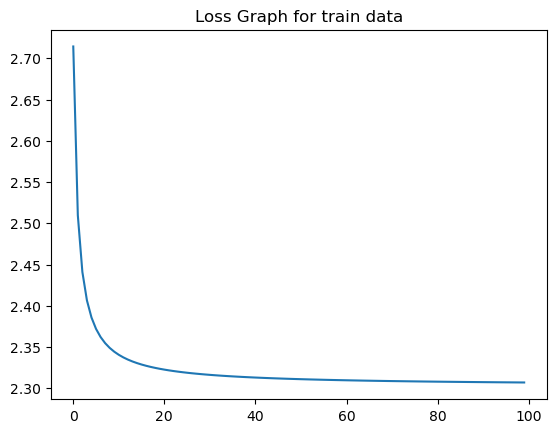

In [83]:
#loss graph for total epochs
print("loss of train: ", total_loss[0], total_loss[-1])

plt.figure()
plt.plot(total_loss)
plt.title("Loss Graph for train data")
plt.show()

In [1]:
##predict
xs_test = []
ys_test = []
y_test_pred = []
acc_test =0.0

#print(y_test_one_hot[0:10])
for x, y in zip(X_test, y_test_one_hot):
    xs_test.append(x)
    ys_test.append(y)
    I = x #(784,1)
    A1 = np.dot(I, W1) + B1
    R1 = relu(A1) #(32,1)
    A2 = np.dot(R1,W2) + B2
    R2 = relu(A2)
    A3 = np.dot(R2, W3) + B3 
    R3 = relu(A3) #(128,1)
    test_O = np.dot(R3, W4) + B4
    test_probs = softmax(test_O)
    test_probs = test_probs[0]
    y_test_pred.append(test_probs)
    if np.argmax(y) == np.argmax(test_probs): 
        acc_test += 1
    else:
        acc_test = acc_test
    #print(y, np.argmax(test_probs))
    
print("number of correct answer", acc_test, "/", len(xs_test))
print("xs_test",len(xs_test))
print("ys_test", len(ys_test))


NameError: name 'X_test' is not defined